In [1]:
from __future__ import division, print_function

import numpy as np
np.random.seed(1500000042)

from scipy.constants import c, epsilon_0, e, m_p

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import h5py

In [2]:
import os
os.environ['CUDA_DEVICE'] = '0'

from pycuda.autoinit import context
from pycuda import gpuarray as gp

In [3]:
import sys
cwd = os.getcwd()
sys.path.append(cwd + '/PyHEADTAIL/')

In [4]:
import PyHEADTAIL

PyHEADTAIL v1.12.4




In [5]:
import PyPIC.GPU as PyPIC

In [6]:
from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.spacecharge.spacecharge import TransverseGaussianSpaceCharge
from PyHEADTAIL.spacecharge.pypic_factory import create_mesh, create_3dmesh_from_beam
from PyHEADTAIL.spacecharge.pypic_spacecharge import SpaceChargePIC
from PyHEADTAIL.monitors.monitors import ParticleMonitor

from PyHEADTAIL.general.printers import SilentPrinter
from PyHEADTAIL.general.contextmanager import CPU, GPU

PyKLU not found


In [7]:
contextmanager = CPU

In [8]:
from PyCERNmachines.CERNmachines import SPS

In [9]:
n_macroparticles = int(1e6)
n_slices_sc = 100

intensity = 1.3e11
epsn_x = epsn_y = 2e-6 # in [m.rad]
sigma_z = 0.23 # in [m]

In [10]:
def make_machine(n_segments=200):
    return SPS(n_segments=n_segments,
               machine_configuration='Q20-injection',
               optics='smooth',
               printer=SilentPrinter(),
               Q_x=20.26,
               Q_y=20.31,
              )

def make_beam(machine=make_machine(), n_macroparticles=n_macroparticles):
    return machine.generate_6D_Gaussian_bunch_matched(
        n_macroparticles, intensity, epsn_x, epsn_y, sigma_z)

In [11]:
machine = make_machine()

In [12]:
beam = make_beam(machine=machine, n_macroparticles=n_macroparticles)

*** PyHEADTAIL WARNING! RFBucketMatcher: failed to converge with Brent method, continuing with Newton-Raphson method.


In [13]:
slicing_interval = machine.longitudinal_map.get_bucket(beam).interval

slicer_sc = UniformBinSlicer(n_slices_sc, z_cuts=slicing_interval)

In [14]:
from PyPIC.GPU.poisson_solver.FFT_solver import GPUFFTPoissonSolver_2_5D, GPUFFTPoissonSolver
from PyPIC.GPU.pypic import PyPIC_GPU, PyPIC

# not necessary but nice: memory pool sharing between PyHEADTAIL and PyPIC
try:
    from PyHEADTAIL.gpu.gpu_utils import memory_pool
except:
    memory_pool = None

In [15]:
# self-consistent PIC solving for space charge
n_mesh_nodes_pic = 256
n_mesh_sigma_pic = 10

In [16]:
mesh_3d = create_3dmesh_from_beam(beam, [n_mesh_nodes_pic]*2, [n_mesh_sigma_pic]*2, 
                                  slices=beam.get_slices(slicer_sc))

In [17]:
assert (machine.optics == 'smooth')
sc_integration_length = machine.circumference / len(machine.transverse_map)

In [18]:
# poissonsolver = GPUFFTPoissonSolver_2_5D(mesh_3d, context=context, save_memory=False)
poissonsolver = GPUFFTPoissonSolver(mesh_3d, context=context)
pypic_algorithm = PyPIC_GPU(mesh_3d, poissonsolver, context=context, 
                            memory_pool=memory_pool)
pic_sc_node = SpaceChargePIC(sc_integration_length, pypic_algorithm)

In [20]:
with GPU(beam):
    routput = %%prun -r pic_sc_node.track(beam)

In [21]:
routput.sort_stats(2).print_stats(40)

         880 function calls (878 primitive calls) in 0.052 seconds

   Ordered by: cumulative time
   List reduced from 85 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.052    0.052 <string>:1(<module>)
        1    0.000    0.000    0.052    0.052 pypic_spacecharge.py:82(track)
        1    0.002    0.002    0.051    0.051 pypic.py:675(pic_solve)
        1    0.000    0.000    0.046    0.046 pypic.py:536(poisson_solve)
        1    0.044    0.044    0.046    0.046 FFT_solver.py:155(poisson_solve)
        9    0.000    0.000    0.002    0.000 contextmanager.py:82(_patch_binop)
        6    0.000    0.000    0.002    0.000 gpuarray.py:485(__mul__)
        1    0.000    0.000    0.002    0.002 pypic.py:549(get_electric_fields)
       19    0.002    0.000    0.002    0.000 gpuarray.py:162(__init__)
        1    0.002    0.002    0.002    0.002 gradient.py:57(_gradient)
       12    0.000    0.000    

<pstats.Stats instance at 0x7f63fa058f38>

In [22]:
%load_ext line_profiler

In [23]:
with GPU(beam):
    lproutput = %%lprun -r -f pic_sc_node.pypic.pic_solve pic_sc_node.track(beam)

In [24]:
lproutput.print_stats()

Timer unit: 1e-06 s

Total time: 0.052965 s
File: PyPIC/GPU/pypic.py
Function: pic_solve at line 675

Line #      Hits         Time  Per Hit   % Time  Line Contents
   675                                               def pic_solve(self, *mp_coords, **kwargs):
   676                                                   '''Encapsulates the whole algorithm to determine the
   677                                                   fields of the particles on themselves.
   678                                                   The keyword argument charge=e is the charge per macro-particle.
   679                                                   Further keyword arguments are
   680                                                   mesh_indices=None, mesh_distances=None, mesh_weights=None .
   681                                           
   682                                                   The optional keyword arguments lower_bounds=False and
   683                                         

In [25]:
with GPU(beam):
    lproutput = %%lprun -r -f pic_sc_node.pypic.poissonsolver.poisson_solve pic_sc_node.track(beam)

In [26]:
lproutput.print_stats()

Timer unit: 1e-06 s

Total time: 0.048126 s
File: PyPIC/GPU/poisson_solver/FFT_solver.py
Function: poisson_solve at line 155

Line #      Hits         Time  Per Hit   % Time  Line Contents
   155                                               def poisson_solve(self, rho):
   156                                                   ''' Solve the poisson equation with the given charge distribution
   157                                                   Args:
   158                                                       rho: Charge distribution (same dimensions as mesh)
   159                                                   Returns:
   160                                                       Phi (same dimensions as rho)
   161                                                   '''
   162         1          114    114.0      0.2          rho = rho.astype(np.complex128)
   163         1            6      6.0      0.0          self._cpyrho2tmp.set_src_device(rho.gpudata)
   164         1      

In [27]:
from PyPIC.GPU.poisson_solver.FFT_solver import GPUFFTPoissonSolver

In [28]:
from scipy.constants import epsilon_0

In [22]:
# import pyfftw

# pyfftw.FFTW()

In [29]:
# try:
#     import pyfftw
    
# except ImportError:
#     cpu_fft = np.fft.fft
#     cpu_ifft = np.fft.ifft

class FFTPoissonSolver(GPUFFTPoissonSolver):
    '''CPU version of GPUFFTPoissonSolver.'''
    def __init__(self, mesh):
        self.mesh = mesh

        # dimensionality function dispatch
        dim = mesh.dimension
        self._fgreen = getattr(super(FFTPoissonSolver, self), '_fgreen' + str(dim) + 'd')
        self._mirror = getattr(super(FFTPoissonSolver, self), '_mirror' + str(dim) + 'd')
        
        self.setup_mesh(mesh)
        
        mesh_shape2 = [2*n for n in mesh.shape] # (2*nz,) 2*ny, 2*nx
        self.tmpspace = np.zeros(mesh_shape2, dtype=np.complex128)
        
        if dim == 2:
            self._slice_window = np.s_[:mesh.ny, :mesh.nx]
        elif dim == 3:
            self._slice_window = np.s_[:mesh.nz, :mesh.ny, :mesh.nx]
        else:
            raise NotImplementedError(
                'Only mesh of dimension 2 and 3 are implemented.')

    def setup_mesh(self, mesh):
        assert (mesh.shape == self.mesh.shape)
        self.mesh = mesh
        mesh_arr = [
            -mesh.distances[i]/2 +
            np.arange(mesh.shape_r[i] + 1.) * mesh.distances[i]
            for i in reversed(xrange(mesh.dimension))
           ]
        # mesh_arr is [mz, my, mx]
        mesh_grids = np.meshgrid(*mesh_arr, indexing='ij')
        fgreen = self._fgreen(*mesh_grids)
        fgreen = self._mirror(fgreen)
        self.fgreentr = np.fft.fft(fgreen)

    def poisson_solve(self, rho):
        ''' Solve the poisson equation with the given charge distribution
        Args:
            rho: Charge distribution (same dimensions as mesh)
        Returns:
            Phi (same dimensions as rho)
        '''
#         rho = rho.astype(np.complex128)
#         cpu_fft(self.tmpspace, self.tmpspace, plan=self.plan_forward)
#         cpu_ifft(self.tmpspace * self.fgreentr, self.tmpspace,
#                  plan=self.plan_backward)
        self.tmpspace.fill(0)
        self.tmpspace[self._slice_window] = rho
        phi = np.fft.ifft(np.fft.fft(self.tmpspace) * self.fgreentr)[self._slice_window]
        phi = phi.real
#         # scale (cuFFT is unscaled)
#         phi = rho.real/(2**self.mesh.dimension * self.mesh.n_nodes)
        phi *= self.mesh.volume_elem/(2**(self.mesh.dimension-1)*np.pi*epsilon_0)
        return phi

In [30]:
cpu_poisson_solver = FFTPoissonSolver(mesh_3d)

In [31]:
cpu_pypic_algorithm = PyPIC(mesh_3d, cpu_poisson_solver)
cpu_pic_sc_node = SpaceChargePIC(sc_integration_length, cpu_pypic_algorithm)

In [30]:
with CPU(beam):
    routput_cpu = %%prun -r cpu_pic_sc_node.track(beam)

In [31]:
routput_cpu.sort_stats(2).print_stats(20)

         3000272 function calls in 176.545 seconds

   Ordered by: cumulative time
   List reduced from 63 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.008    0.008  176.545  176.545 <string>:1(<module>)
        1    0.046    0.046  176.537  176.537 pypic_spacecharge.py:82(track)
        1    0.015    0.015  176.490  176.490 pypic.py:172(pic_solve)
        1    0.010    0.010  129.350  129.350 pypic.py:88(particles_to_mesh)
        1  129.061  129.061  129.075  129.075 p2m.py:8(particles_to_mesh_CPU_3d)
        1    0.000    0.000   46.608   46.608 pypic.py:140(field_to_particles)
        3    0.000    0.000   46.407   15.469 pypic.py:123(mesh_to_particles)
        3    0.431    0.144   45.830   15.277 m2p.py:8(mesh_to_particles_CPU_3d)
        3    0.024    0.008   45.281   15.094 function_base.py:1944(__call__)
        3    1.849    0.616   45.257   15.086 function_base.py:2035(_vectorize_call)
  3000003   43.27

<pstats.Stats instance at 0x7f2ee81a71b8>

### improving p2m and m2p on CPU

In [36]:
with open('p2m_cpu.c', 'wt') as fh:
    fh.write('''
#include <math.h>

void p2m_rectmesh3d_64atomics(
        // INPUTS:
          // length of x, y, z arrays
        const int nparticles,
          // particle positions
        double* x, double* y, double* z,
          // mesh origin
        const double x0, const double y0, const double z0,
          // mesh distances per cell
        const double dx, const double dy, const double dz,
          // mesh dimension (number of cells)
        const int nx, const int ny, const int nz,
        // OUTPUTS:
        double *grid1d
) {
    int jx, ix, kx;
    double dxi, dyi, dzi, wijk, wi1jk, wij1k, wi1j1k, wijk1, wi1jk1, wij1k1, wi1j1k1;
    for (int pidx = 0; pidx < nparticles; pidx++)
    {
        // indices
        jx = floor((x[pidx] - x0) / dx);
        ix = floor((y[pidx] - y0) / dy);
        kx = floor((z[pidx] - z0) / dz);

        // distances
        dxi = x[pidx] - (x0 + jx * dx);
        dyi = y[pidx] - (y0 + ix * dy);
        dzi = z[pidx] - (z0 + kx * dz);

        // weights
        wijk =    (1.-dxi/dx)*(1.-dyi/dy)*(1.-dzi/dz);
        wi1jk =   (1.-dxi/dx)*(dyi/dy)   *(1.-dzi/dz);
        wij1k =   (dxi/dx)   *(1.-dyi/dy)*(1.-dzi/dz);
        wi1j1k =  (dxi/dx)   *(dyi/dy)   *(1.-dzi/dz);
        wijk1 =   (1.-dxi/dx)*(1.-dyi/dy)*(dzi/dz);
        wi1jk1 =  (1.-dxi/dx)*(dyi/dy)   *(dzi/dz);
        wij1k1 =  (dxi/dx)   *(1.-dyi/dy)*(dzi/dz);
        wi1j1k1 = (dxi/dx)   *(dyi/dy)   *(dzi/dz);

        if (jx >= 0 && jx < nx - 1 && ix >= 0 && ix < ny - 1 && kx >= 0 && kx < nz - 1)
        {
            grid1d[jx   + ix*nx     + kx*nx*ny]     += wijk;
            grid1d[jx+1 + ix*nx     + kx*nx*ny]     += wij1k;
            grid1d[jx   + (ix+1)*nx + kx*nx*ny]     += wi1jk;
            grid1d[jx+1 + (ix+1)*nx + kx*nx*ny]     += wi1j1k;
            grid1d[jx   + ix*nx     + (kx+1)*nx*ny] += wijk1;
            grid1d[jx+1 + ix*nx     + (kx+1)*nx*ny] += wij1k1;
            grid1d[jx   + (ix+1)*nx + (kx+1)*nx*ny] += wi1jk1;
            grid1d[jx+1 + (ix+1)*nx + (kx+1)*nx*ny] += wi1j1k1;
        }
    }
}

void p2m_rectmesh2d_64atomics(
        // INPUTS:
          // length of x, y arrays
        const int nparticles,
          // particle positions
        double* x, double* y,
          // mesh origin
        const double x0, const double y0,
          // mesh distances per cell
        const double dx, const double dy,
          // mesh dimension (number of cells)
        const int nx, const int ny,
        // OUTPUTS:
        double *grid1d
) {
    int jx, ix;
    double dxi, dyi, wij, wi1j, wij1, wi1j1;
    for (int pidx = 0; pidx < nparticles; pidx++)
    {
        // indices
        jx = floor((x[pidx] - x0) / dx);
        ix = floor((y[pidx] - y0) / dy);

        // distances
        dxi = x[pidx] - (x0 + jx * dx);
        dyi = y[pidx] - (y0 + ix * dy);

        // weights
        wij =    (1.-dxi/dx)*(1.-dyi/dy);
        wi1j =   (1.-dxi/dx)*(dyi/dy)   ;
        wij1 =   (dxi/dx)   *(1.-dyi/dy);
        wi1j1 =  (dxi/dx)   *(dyi/dy)   ;

        if (jx >= 0 && jx < nx - 1 && ix >= 0 && ix < ny - 1)
        {
            grid1d[jx + ix*nx]       += wij;
            grid1d[jx+1 + ix*nx]     += wij1;
            grid1d[jx + (ix+1)*nx]   += wi1j;
            grid1d[jx+1 + (ix+1)*nx] += wi1j1;
        }
    }
}
''')

In [37]:
!gcc -std=c99 -O3 -fPIC -shared -o p2m_cpu.so p2m_cpu.c -lm

In [38]:
import ctypes

from numpy.ctypeslib import ndpointer
np_double_p = ndpointer(dtype=np.float64)

In [39]:
p2m_dll = ctypes.cdll.LoadLibrary('./p2m_cpu.so')

p2m_dll.p2m_rectmesh3d_64atomics.restype = None
p2m_dll.p2m_rectmesh3d_64atomics.argtypes = [
    ctypes.c_int, 
    np_double_p, np_double_p, np_double_p,
    ctypes.c_double, ctypes.c_double, ctypes.c_double, 
    ctypes.c_double, ctypes.c_double, ctypes.c_double, 
    ctypes.c_int, ctypes.c_int, ctypes.c_int,
    np_double_p, 
]

p2m_dll.p2m_rectmesh2d_64atomics.restype = None
p2m_dll.p2m_rectmesh2d_64atomics.argtypes = [
    ctypes.c_int, 
    np_double_p, np_double_p,
    ctypes.c_double, ctypes.c_double,
    ctypes.c_double, ctypes.c_double,
    ctypes.c_int, ctypes.c_int,
    np_double_p, 
]

In [40]:
def p2m_cpu(self, *mp_coords, **kwargs):
    charge = kwargs.get("charge", e)
    
    mesh_count = np.zeros(self.mesh.shape, dtype=float).flatten()
    
    if "RectMesh" in str(self.mesh.__class__) and \
            self.mesh.dimension in [2,3]:
        p2m_fct = getattr(
            p2m_dll, 'p2m_rectmesh' + str(self.mesh.dimension) + 'd_64atomics')
        args = [ctypes.c_int(len(mp_coords[0]))]
        args += mp_coords
        args += list(map(ctypes.c_double, self.mesh.origin))
        args += list(map(ctypes.c_double, self.mesh.distances))
        args += list(map(ctypes.c_int, self.mesh.shape_r))
        args += [mesh_count]

        p2m_fct(*args)
    else:
        raise NotImplementedError('Only 2/3D rectangular meshes for now..')
    
    mesh_count = mesh_count.reshape(self.mesh.shape)
    return mesh_count * charge

In [41]:
res = p2m_cpu(cpu_pypic_algorithm, beam.x, beam.y, beam.z)

In [42]:
with GPU(beam):
    res2 = pypic_algorithm.particles_to_mesh(beam.x, beam.y, beam.z)

relative error:

In [43]:
np.max((res - res2.get())/e) / np.max(res/e)

2.5175457539149297e-06

In [44]:
with open('m2p_cpu.c', 'wt') as fh:
    fh.write('''
#include <math.h>

void m2p_rectmesh2d_scalar(
    // INPUTS:
      // length of x, y arrays
    const int nparticles,
      // particle positions
    double* x, double* y,
      // mesh origin
    const double x0, const double y0,
      // mesh distances per cell
    const double dx, const double dy,
      // mesh dimension (number of cells)
    const int nx, const int ny,
      // scalar field defined over mesh
    double *mesh_quantity,
    // OUTPUTS:
    double* particles_quantity
) {
    int jx, ix;
    double dxi, dyi, wij, wi1j, wij1, wi1j1;
    for (int pidx = 0; pidx < nparticles; pidx++)
    {
        // indices
        jx = floor((x[pidx] - x0) / dx);
        ix = floor((y[pidx] - y0) / dy);

        // distances
        dxi = x[pidx] - (x0 + jx * dx);
        dyi = y[pidx] - (y0 + ix * dy);

        // weights
        wij =    (1.-dxi/dx)*(1.-dyi/dy);
        wi1j =   (1.-dxi/dx)*(dyi/dy)   ;
        wij1 =   (dxi/dx)   *(1.-dyi/dy);
        wi1j1 =  (dxi/dx)   *(dyi/dy)   ;

        if (jx >= 0 && jx < nx - 1 && ix >= 0 && ix < ny - 1)
        {
            particles_quantity[pidx] = ( wij   * mesh_quantity[jx   + ix*nx]
                                       + wij1  * mesh_quantity[jx+1 + ix*nx]
                                       + wi1j  * mesh_quantity[jx+  + (ix+1)*nx]
                                       + wi1j1 * mesh_quantity[jx+1 + (ix+1)*nx]);
        } else {
            particles_quantity[pidx] = 0;
        }
    }
}

void m2p_rectmesh2d_vector(
    // INPUTS:
      // length of x, y arrays
    const int nparticles,
      // particle positions
    double* x, double* y,
      // mesh origin
    const double x0, const double y0,
      // mesh distances per cell
    const double dx, const double dy,
      // mesh dimension (number of cells)
    const int nx, const int ny,
      // field vector components defined over mesh
    double* fieldx, double* fieldy,
    // OUTPUTS:
    double* forcex, double* forcey
) {
    int jx, ix;
    double dxi, dyi, wij, wi1j, wij1, wi1j1;
    for (int pidx = 0; pidx < nparticles; pidx++)
    {
        // indices
        jx = floor((x[pidx] - x0) / dx);
        ix = floor((y[pidx] - y0) / dy);

        // distances
        dxi = x[pidx] - (x0 + jx * dx);
        dyi = y[pidx] - (y0 + ix * dy);

        // weights
        wij =    (1.-dxi/dx)*(1.-dyi/dy);
        wi1j =   (1.-dxi/dx)*(dyi/dy)   ;
        wij1 =   (dxi/dx)   *(1.-dyi/dy);
        wi1j1 =  (dxi/dx)   *(dyi/dy)   ;

        if (jx >= 0 && jx < nx - 1 && ix >= 0 && ix < ny - 1)
        {
            forcex[pidx] =    ( wij *  fieldx[jx + ix*nx]
                              + wij1 * fieldx[jx+1 + ix*nx]
                              + wi1j * fieldx[jx + (ix+1)*nx]
                              + wi1j1 *fieldx[jx+1 + (ix+1)*nx]);
            forcey[pidx] =    ( wij *  fieldy[jx + ix*nx]
                              + wij1 * fieldy[jx+1 + ix*nx]
                              + wi1j * fieldy[jx + (ix+1)*nx]
                              + wi1j1 *fieldy[jx+1 + (ix+1)*nx]);
        } else {
            forcex[pidx] = 0;
            forcey[pidx] = 0;
        }
    }
}


// RectMesh3D variants

void m2p_rectmesh3d_scalar(
    // INPUTS:
      // length of x, y, z arrays
    const int nparticles,
      // particle positions
    double* x, double* y, double* z,
      // mesh origin
    const double x0, const double y0, const double z0,
      // mesh distances per cell
    const double dx, const double dy, const double dz,
      // mesh dimension (number of cells)
    const int nx, const int ny, const int nz,
      // scalar field defined over mesh
    double *mesh_quantity,
    // OUTPUTS:
    double* particles_quantity
) {
    int jx, ix, kx;
    double dxi, dyi, dzi, wijk, wi1jk, wij1k, wi1j1k, wijk1, wi1jk1, wij1k1, wi1j1k1;
    for (int pidx = 0; pidx < nparticles; pidx++)
    {
        // indices
        jx = floor((x[pidx] - x0) / dx);
        ix = floor((y[pidx] - y0) / dy);
        kx = floor((z[pidx] - z0) / dz);

        // distances
        dxi = x[pidx] - (x0 + jx * dx);
        dyi = y[pidx] - (y0 + ix * dy);
        dzi = z[pidx] - (z0 + kx * dz);

        // weights
        wijk =    (1.-dxi/dx)*(1.-dyi/dy)*(1.-dzi/dz);
        wi1jk =   (1.-dxi/dx)*(dyi/dy)   *(1.-dzi/dz);
        wij1k =   (dxi/dx)   *(1.-dyi/dy)*(1.-dzi/dz);
        wi1j1k =  (dxi/dx)   *(dyi/dy)   *(1.-dzi/dz);
        wijk1 =   (1.-dxi/dx)*(1.-dyi/dy)*(dzi/dz);
        wi1jk1 =  (1.-dxi/dx)*(dyi/dy)   *(dzi/dz);
        wij1k1 =  (dxi/dx)   *(1.-dyi/dy)*(dzi/dz);
        wi1j1k1 = (dxi/dx)   *(dyi/dy)   *(dzi/dz);

        if (jx >= 0 && jx < nx - 1 && ix >= 0 && ix < ny - 1 && kx >= 0 && kx < nz - 1)
        {
            particles_quantity[pidx] = ( wijk   * mesh_quantity[jx   + ix*nx     + kx*nx*ny]
                                       + wij1k  * mesh_quantity[jx+1 + ix*nx     + kx*nx*ny]
                                       + wi1jk  * mesh_quantity[jx+  + (ix+1)*nx + kx*nx*ny]
                                       + wi1j1k * mesh_quantity[jx+1 + (ix+1)*nx + kx*nx*ny]
                                       + wijk1  * mesh_quantity[jx   + ix*nx     + (kx+1)*nx*ny]
                                       + wij1k1 * mesh_quantity[jx+1 + ix*nx     + (kx+1)*nx*ny]
                                       + wi1jk1 * mesh_quantity[jx+  + (ix+1)*nx + (kx+1)*nx*ny]
                                       + wi1j1k1* mesh_quantity[jx+1 + (ix+1)*nx + (kx+1)*nx*ny]);
        } else {
            particles_quantity[pidx] = 0;
        }
    }
}

void m2p_rectmesh3d_vector(
    // INPUTS:
      // length of x, y, z arrays
    const int nparticles,
      // particle positions
    double* x, double* y, double* z,
      // mesh origin
    const double x0, const double y0, const double z0,
      // mesh distances per cell
    const double dx, const double dy, const double dz,
      // mesh dimension (number of cells)
    const int nx, const int ny, const int nz,
      // field vector components defined over mesh
    double* fieldx, double* fieldy, double* fieldz,
    // OUTPUTS:
    double* forcex, double* forcey, double* forcez
) {
    int jx, ix, kx;
    double dxi, dyi, dzi, wijk, wi1jk, wij1k, wi1j1k, wijk1, wi1jk1, wij1k1, wi1j1k1;
    for (int pidx = 0; pidx < nparticles; pidx++)
    {
        // indices
        jx = floor((x[pidx] - x0) / dx);
        ix = floor((y[pidx] - y0) / dy);
        kx = floor((z[pidx] - z0) / dz);

        // distances
        dxi = x[pidx] - (x0 + jx * dx);
        dyi = y[pidx] - (y0 + ix * dy);
        dzi = z[pidx] - (z0 + kx * dz);

        // weights
        wijk =    (1.-dxi/dx)*(1.-dyi/dy)*(1.-dzi/dz);
        wi1jk =   (1.-dxi/dx)*(dyi/dy)   *(1.-dzi/dz);
        wij1k =   (dxi/dx)   *(1.-dyi/dy)*(1.-dzi/dz);
        wi1j1k =  (dxi/dx)   *(dyi/dy)   *(1.-dzi/dz);
        wijk1 =   (1.-dxi/dx)*(1.-dyi/dy)*(dzi/dz);
        wi1jk1 =  (1.-dxi/dx)*(dyi/dy)   *(dzi/dz);
        wij1k1 =  (dxi/dx)   *(1.-dyi/dy)*(dzi/dz);
        wi1j1k1 = (dxi/dx)   *(dyi/dy)   *(dzi/dz);

        if (jx >= 0 && jx < nx - 1 && ix >= 0 && ix < ny - 1 && kx >= 0 && kx < nz - 1)
        {
            forcex[pidx] = ( wijk   * fieldx[jx   + ix*nx     + kx*nx*ny]
                           + wij1k  * fieldx[jx+1 + ix*nx     + kx*nx*ny]
                           + wi1jk  * fieldx[jx+  + (ix+1)*nx + kx*nx*ny]
                           + wi1j1k * fieldx[jx+1 + (ix+1)*nx + kx*nx*ny]
                           + wijk1  * fieldx[jx   + ix*nx     + (kx+1)*nx*ny]
                           + wij1k1 * fieldx[jx+1 + ix*nx     + (kx+1)*nx*ny]
                           + wi1jk1 * fieldx[jx+  + (ix+1)*nx + (kx+1)*nx*ny]
                           + wi1j1k1* fieldx[jx+1 + (ix+1)*nx + (kx+1)*nx*ny]);

            forcey[pidx] = ( wijk   * fieldy[jx   + ix*nx     + kx*nx*ny]
                           + wij1k  * fieldy[jx+1 + ix*nx     + kx*nx*ny]
                           + wi1jk  * fieldy[jx+  + (ix+1)*nx + kx*nx*ny]
                           + wi1j1k * fieldy[jx+1 + (ix+1)*nx + kx*nx*ny]
                           + wijk1  * fieldy[jx   + ix*nx     + (kx+1)*nx*ny]
                           + wij1k1 * fieldy[jx+1 + ix*nx     + (kx+1)*nx*ny]
                           + wi1jk1 * fieldy[jx+  + (ix+1)*nx + (kx+1)*nx*ny]
                           + wi1j1k1* fieldy[jx+1 + (ix+1)*nx + (kx+1)*nx*ny]);

            forcez[pidx] = ( wijk   * fieldz[jx   + ix*nx     + kx*nx*ny]
                           + wij1k  * fieldz[jx+1 + ix*nx     + kx*nx*ny]
                           + wi1jk  * fieldz[jx+  + (ix+1)*nx + kx*nx*ny]
                           + wi1j1k * fieldz[jx+1 + (ix+1)*nx + kx*nx*ny]
                           + wijk1  * fieldz[jx   + ix*nx     + (kx+1)*nx*ny]
                           + wij1k1 * fieldz[jx+1 + ix*nx     + (kx+1)*nx*ny]
                           + wi1jk1 * fieldz[jx+  + (ix+1)*nx + (kx+1)*nx*ny]
                           + wi1j1k1* fieldz[jx+1 + (ix+1)*nx + (kx+1)*nx*ny]);
        } else {
            forcex[pidx] = 0;
            forcey[pidx] = 0;
            forcez[pidx] = 0;
        }
    }
}
''')

In [45]:
!gcc -std=c99 -O3 -fPIC -shared -o m2p_cpu.so m2p_cpu.c -lm

In [46]:
m2p_dll = ctypes.cdll.LoadLibrary('./m2p_cpu.so')

m2p_dll.m2p_rectmesh2d_scalar.restype = None
m2p_dll.m2p_rectmesh2d_scalar.argtypes = [
    ctypes.c_int, 
    np_double_p, np_double_p,
    ctypes.c_double, ctypes.c_double,
    ctypes.c_double, ctypes.c_double,
    ctypes.c_int, ctypes.c_int,
    np_double_p, 
    np_double_p, 
]

m2p_dll.m2p_rectmesh2d_vector.restype = None
m2p_dll.m2p_rectmesh2d_vector.argtypes = [
    ctypes.c_int, 
    np_double_p, np_double_p,
    ctypes.c_double, ctypes.c_double,
    ctypes.c_double, ctypes.c_double,
    ctypes.c_int, ctypes.c_int,
    np_double_p, np_double_p, np_double_p,
    np_double_p, np_double_p, np_double_p,
]

m2p_dll.m2p_rectmesh3d_scalar.restype = None
m2p_dll.m2p_rectmesh3d_scalar.argtypes = [
    ctypes.c_int, 
    np_double_p, np_double_p, np_double_p,
    ctypes.c_double, ctypes.c_double, ctypes.c_double, 
    ctypes.c_double, ctypes.c_double, ctypes.c_double, 
    ctypes.c_int, ctypes.c_int, ctypes.c_int,
    np_double_p, 
    np_double_p, 
]

m2p_dll.m2p_rectmesh3d_vector.restype = None
m2p_dll.m2p_rectmesh3d_vector.argtypes = [
    ctypes.c_int, 
    np_double_p, np_double_p, np_double_p,
    ctypes.c_double, ctypes.c_double, ctypes.c_double, 
    ctypes.c_double, ctypes.c_double, ctypes.c_double, 
    ctypes.c_int, ctypes.c_int, ctypes.c_int,
    np_double_p, np_double_p, np_double_p,
    np_double_p, np_double_p, np_double_p,
]

In [47]:
def m2p_cpu(self, mesh_quantity, *mp_coords, **kwargs):
    n_macroparticles = len(mp_coords[0])
    
    particles_quantity = np.empty(n_macroparticles, dtype=np.float64)
    
    if "RectMesh" in str(self.mesh.__class__) and \
            self.mesh.dimension in [2,3]:
        m2p_fct = getattr(
            m2p_dll, 'm2p_rectmesh' + str(self.mesh.dimension) + 'd_scalar')
        args = [ctypes.c_int(n_macroparticles)]
        args += mp_coords
        args += list(map(ctypes.c_double, self.mesh.origin))
        args += list(map(ctypes.c_double, self.mesh.distances))
        args += list(map(ctypes.c_int, self.mesh.shape_r))
        args += [mesh_quantity, particles_quantity]

        m2p_fct(*args)
    else:
        raise NotImplementedError('Only 2/3D rectangular meshes for now..')

    return particles_quantity

In [48]:
rho = p2m_cpu(cpu_pypic_algorithm, beam.x, beam.y, beam.z) / cpu_pypic_algorithm.mesh.volume_elem
phi = cpu_pypic_algorithm.poisson_solve(rho)
efields = cpu_pypic_algorithm.get_electric_fields(phi)

In [49]:
res = m2p_cpu(cpu_pypic_algorithm, efields[0], beam.x, beam.y, beam.z)

In [50]:
with GPU(beam):
    res2 = pypic_algorithm.mesh_to_particles(gp.to_gpu(efields[0]), beam.x, beam.y, beam.z)

relative error:

In [51]:
np.max(np.abs((res - res2.get()))) / np.max(np.abs(res))

1.7515254535777417e-14

In [52]:
def fields2p_cpu(self, *mesh_fields_and_mp_coords, **kwargs):
    mesh_fields, mp_coords = zip(*mesh_fields_and_mp_coords)
    
    n_macroparticles = len(mp_coords[0])
    
    # field per particle
    particle_fields = [
        np.empty(n_macroparticles, dtype=np.float64)
        for _ in mesh_fields]
    
    if "RectMesh" in str(self.mesh.__class__) and \
            self.mesh.dimension in [2,3]:
        m2p_fct = getattr(
            m2p_dll, 'm2p_rectmesh' + str(self.mesh.dimension) + 'd_vector')
        args = [ctypes.c_int(n_macroparticles)]
        args += mp_coords
        args += list(map(ctypes.c_double, self.mesh.origin))
        args += list(map(ctypes.c_double, self.mesh.distances))
        args += list(map(ctypes.c_int, self.mesh.shape_r))
        args += list(mesh_fields) + particle_fields

        m2p_fct(*args)
    else:
        raise NotImplementedError('Only 2/3D rectangular meshes for now..')

    return particle_fields

In [53]:
cpu_args = zip(list(efields), [beam.x, beam.y, beam.z])

In [54]:
res = fields2p_cpu(cpu_pypic_algorithm, *cpu_args)

In [55]:
with GPU(beam):
    gpu_args = zip(map(gp.to_gpu, efields), [beam.x, beam.y, beam.z])
    res2 = pypic_algorithm.field_to_particles(*gpu_args)

relative error:

In [56]:
np.max(np.abs((res[0] - res2[0].get()))) / np.max(np.abs(res[0]))

1.7515254535777417e-14

##### timing

In [57]:
from types import MethodType

In [58]:
cpu_pypic_algorithm_fast = PyPIC(mesh_3d, cpu_poisson_solver)

cpu_pypic_algorithm_fast.particles_to_mesh = MethodType(p2m_cpu, cpu_pypic_algorithm_fast, PyPIC)
cpu_pypic_algorithm_fast.mesh_to_particles = MethodType(m2p_cpu, cpu_pypic_algorithm_fast, PyPIC)
cpu_pypic_algorithm_fast.field_to_particles = MethodType(fields2p_cpu, cpu_pypic_algorithm_fast, PyPIC)

cpu_pic_sc_node_fast = SpaceChargePIC(sc_integration_length, cpu_pypic_algorithm_fast)

In [59]:
with CPU(beam):
    routput_cpu = %%prun -r cpu_pic_sc_node_fast.track(beam)

In [60]:
routput_cpu.sort_stats(2).print_stats(20)

         137 function calls in 1.455 seconds

   Ordered by: cumulative time
   List reduced from 46 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.455    1.455 <string>:1(<module>)
        1    0.131    0.131    1.455    1.455 pypic_spacecharge.py:82(track)
        1    0.065    0.065    1.323    1.323 pypic.py:172(pic_solve)
        1    0.000    0.000    0.805    0.805 pypic.py:108(poisson_solve)
        1    0.346    0.346    0.805    0.805 <ipython-input-29-edcac8237c54>:45(poisson_solve)
        1    0.306    0.306    0.306    0.306 {method 'fill' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.255    0.255 pypic.py:116(get_electric_fields)
        1    0.051    0.051    0.255    0.255 gradient.py:71(_gradient)
        1    0.204    0.204    0.204    0.204 function_base.py:738(gradient)
        1    0.109    0.109    0.109    0.109 <ipython-input-52-b90f1764ba40>:1(fields2p_cpu)


<pstats.Stats instance at 0x7f644952ac20>

GPU (Tesla C2075) version: 0.180s

- p2m: 0.019s
- solve: 0.141s
- m2p: 0.000s

fast CPU version: 0.568s

- p2m: 0.106s
- solve: 0.234s
- m2p: 0.139s

### results

In [65]:
xp0 = beam.xp.copy()
with GPU(beam):
    pic_sc_node.track(beam)
xp_gpu = beam.xp - xp0

(-2.6538455235629245e-07, 2.650363786111258e-07)

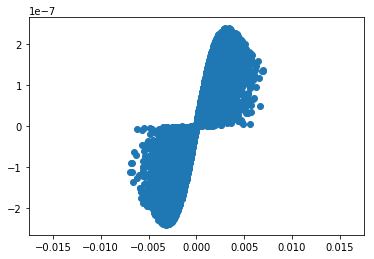

In [66]:
plt.scatter(beam.x[::100], xp_gpu[::100])
plt.ylim(xp_gpu.min() * 1.1, xp_gpu.max() * 1.1)

In [67]:
xp0 = beam.xp.copy()
with CPU(beam):
    cpu_pic_sc_node_fast.track(beam)
xp_cpu = beam.xp - xp0

(-9.554396119756948e-17, 9.606573349307813e-17)

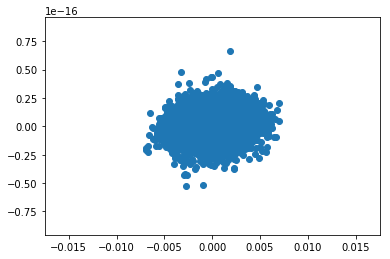

In [68]:
plt.scatter(beam.x[::100], xp_cpu[::100])
plt.ylim(xp_cpu.min() * 1.1, xp_cpu.max() * 1.1)

$\implies$ don't forget, solving on CPU is still wrong, bug somewhere...

### why is the GPU solve so slow?

In [91]:
rho = p2m_cpu(cpu_pypic_algorithm, beam.x, beam.y, beam.z) / cpu_pypic_algorithm.mesh.volume_elem
rho_gpu = gp.to_gpu(rho)

In [92]:
with CPU(beam):
    routput_gpu = %%prun -r pypic_algorithm.poisson_solve(rho_gpu)

In [100]:
routput_gpu.sort_stats(2).print_stats()

         189 function calls in 0.144 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.144    0.144 <string>:1(<module>)
        1    0.001    0.001    0.144    0.144 pypic.py:536(poisson_solve)
        1    0.138    0.138    0.143    0.143 FFT_solver.py:155(poisson_solve)
        4    0.000    0.000    0.003    0.001 gpuarray.py:412(_new_like_me)
        4    0.003    0.001    0.003    0.001 gpuarray.py:162(__init__)
        2    0.000    0.000    0.002    0.001 contextmanager.py:82(_patch_binop)
        1    0.000    0.000    0.002    0.002 gpuarray.py:485(__mul__)
        1    0.000    0.000    0.001    0.001 gpuarray.py:723(astype)
        2    0.000    0.000    0.001    0.001 fft.py:169(_fft)
        2    0.001    0.000    0.001    0.000 cufft.py:368(cufftExecZ2Z)
        1    0.000    0.000    0.001    0.001 fft.py:220(fft)
        1    0.000    0.000    0.000    0.000 gpuarray.py:961(

<pstats.Stats instance at 0x7f6cf2a51518>

.

.

.

.

In [33]:
machine.install_after_each_transverse_segment(pic_sc_node)

In [35]:
transv_one_turn_map = [el for el in machine.one_turn_map if el is not machine.longitudinal_map]

In [36]:
n_turns = 128

In [ ]:
# with contextmanager(beam):
#     for _ in range(n_turns):
#         for el in transv_one_turn_map:
#             el.track(beam)
#         pmonitor.dump(beam)